[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/me-manu/gammaALPs/blob/master/docs/tutorials/mixing_AGN_jet_simple.ipynb)

# Mixing in AGN jet with simple toroidal magnetic field

In this example, we will consider the conversion in the AGN jet and the Galactic mangetic field.
The environments that are used are `MixJet` and `MixGMF` and we also include absorption in the EBL through the `EBL`
enviroment. 
For defineteness, we will use the source 3C454.3, a flat spectrum radio quasar from which giant flares at $\gamma$-ray energies were detected with the Fermi LAT. 
The magnetic fields assumed for the blazar are taken from Kutkin et al. (2014), http://adsabs.harvard.edu/abs/2014MNRAS.437.3396K 

If you haven't installed `gammaALPs` already, you can do so using `pip`. Just uncomment the line below:

In [1]:
#!pip install gammaALPs

## Imports

We start with the usual imports

In [2]:
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer
import numpy as np
import matplotlib.pyplot as plt
from ebltable.tau_from_model import OptDepth
from astropy import constants as c
from matplotlib.patheffects import withStroke
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, PathPatch
from matplotlib.text import TextPath
from matplotlib.transforms import Affine2D
from astropy import units as u

effect  = dict(path_effects=[withStroke(foreground="w", linewidth=2)])  # for plotting

%matplotlib inline

## Defining the source

Next we set up the source parameters, taken e.g. from NED, http://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=3C454.3&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES.

Note that we also provide the bulk Lorentz factor $\Gamma = 15.6$ and the observation angle in degrees, $\theta = 1.3^\circ$, according to Kutkin et al., who used average values from Jorstad et al. (2005). These values yield the Doppler factor, $\delta \sim 27.7$.

In [3]:
src = Source(z=0.859000, ra='22h53m57.7s', dec='+16d08m54s',
            bLorentz=15.6, theta_obs=1.3)  # 3C454.3
print (src.z)
print (src.ra, src.dec)
print (src.l, src.b)
print (src._doppler)

0.859
343.49041666666665 16.148333333333333
86.11095204202923 -38.18360971586448
27.707499216562937


## Init the module list

Now we set up the module list with some arbitrary ALP parameters. The energy range is motivated from the Fermi-LAT energy range.

In [4]:
EGeV = np.logspace(-2,4.,2000)

Here's the initial polarization matrix, for which we assume an unpolarized beam.

In [5]:
pin = np.diag((1.,1.,0.)) * 0.5

With these choices, we initialize the module list.

In [6]:
ml = ModuleList(ALP(m= 1., g = 2.), src, pin=pin, EGeV=EGeV)

Now we add the modules:

In [7]:
gamma_min = 1.
ml.add_propagation("Jet", 
                  0,  # position of module counted from the source. 
                  B0=0.32,  # Jet field at r = R0 in G 
                  r0=1.,  # distance from BH where B = B0 in pc
                  rgam=3.19e17 * u.cm.to('pc'),  # distance of gamma-ray emitting region to BH
                  alpha=-1.,  # exponent of toroidal mangetic field (default: -1.)
                  psi=np.pi/4.,  # Angle between one photon polarization state and B field. 
                                 # Assumed constant over entire jet. 
                  helical=True,  # if True, use helical magnetic-field model from Clausen-Brown et al. (2011). 
                                 # In this case, the psi kwarg is treated is as the phi angle 
                                 # of the photon trajectory in the cylindrical jet coordinate system
                  equipartition=True,  # if true, assume equipartition between electrons and the B field. 
                                       # This will overwrite the exponent of electron density beta = 2 * alpha 
                                       # and set n0 given the minimum electron lorentz factor set with gamma_min
                  gamma_min=gamma_min,  # minimum lorentz factor of emitting electrons, only used if equipartition=True
                  gamma_max=np.exp(10.) * gamma_min,  # maximum lorentz factor of emitting electrons,
                                                      # only used if equipartition=True
                  Rjet= 40.,  # maximum jet length in pc (default: 1000.)
                  n0=1e4,  # normalization of electron density, overwritten if equipartition=True
                  beta=-2.    # power-law index of electron density, overwritten if equipartition=True
                 )
ml.add_propagation("EBL", 1, eblmodel='dominguez')  # EBL attenuation comes second, after beam has left cluster
ml.add_propagation("GMF", 2, model='jansson12' )  # finally, the beam enters the Milky Way Field

environs.py: 758 --- INFO: Assuming equipartion at r0: n0(r0) = 7.513e+01 cm^-3
environs.py: 767 --- INFO: Using inputted chi
environs.py:1196 --- INFO: Using inputted chi


### A comment on the geometry adopted in gammaALPs

To calculate the Galactic magnetic field parallel to the two photon polarization states, a local coordinate system along the line of sight is defined and the B field is projected onto the transversal axis, which are called $\hat{l}$ and $\hat{b}$, see the 3D plot below. 

In the above example, we are also dealing with a the jet magnetic field and have set the angle $\psi$ angle, i.e., the angle between the $\hat{y}$ axis in the source frame and the $B$ field.
This angle is related to the local coordinate system through 
$$ \tan\psi = \frac{\langle \vec{B}, \hat{l}\rangle}{\langle \vec{B}, -\hat{b}\rangle}.$$ 

The coordinate system is shown in the example below. 

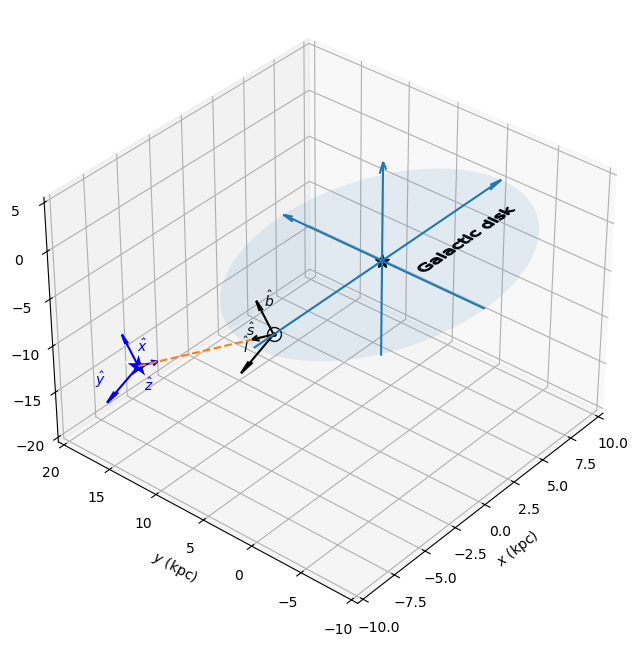

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


# Earth and GC position
ax.plot(-8.5, 0., ms=10, mec='k', mfc='w', marker='o')
ax.plot(-8.5, 0., ms=5, color='k', marker='.')
ax.plot(0., 0., ms=10, color='k', marker='*')

# Axes
start = -10.
length = 20.
axes = [[start, 0., 0., length, 0., 0.], 
        [0., start, 0., 0., length, 0.], 
        [0., 0., start, 0., 0., length]]
X, Y, Z, U, V, W = zip(*axes)
        
ax.quiver(X, Y, Z, U, V, W, arrow_length_ratio=.05, normalize=False)

# arrows to source
x_earth, y_earth, z_earth = np.array([-8.5]), np.array([0.]), np.array([0.])

def uvw_gal(l, b, shift_b=0., shift_l=0.):
    if np.isscalar(l):
        l = np.array([l])
    if np.isscalar(b):
        b = np.array([b])
        
    u = np.cos(np.deg2rad(b) + shift_b) * np.cos(np.deg2rad(l) + shift_l)
    v = np.cos(np.deg2rad(b) + shift_b) * np.sin(np.deg2rad(l) + shift_l)
    w = np.sin(np.deg2rad(src.b) + shift_b)
    
    return u,v,w
                                       

source_distance = 20.
u, v, w = uvw_gal(src.l, src.b)

# arrow to source
ax.quiver(x_earth, y_earth, z_earth, 
          u, v, w, 
          arrow_length_ratio=.001, normalize=False, length=source_distance, color="C1", ls='--')

# local coordinate system at Earth
ax.quiver(x_earth, y_earth, z_earth, 
          u, v, w, 
          arrow_length_ratio=.3, normalize=True, length=3., color="k", ls='-')
ax.text((x_earth + u)[0] - 1.5, (y_earth + v)[0], (z_earth + w)[0] + 1.5,
        "$\hat{s}$", color='k')


u, v, w = uvw_gal(src.l + 90., src.b)
ax.quiver(x_earth, y_earth, z_earth, 
          u, v, w, 
          arrow_length_ratio=.3, normalize=True, length=3., color="k", ls='-')
ax.text((x_earth + u)[0], (y_earth + v)[0] + 2., (z_earth + w)[0]-1.5,
        "$\hat{l}$", color='k')

u, v, w = uvw_gal(src.l, src.b, shift_b=np.pi / 2.)
ax.quiver(x_earth, y_earth, z_earth, 
          u, v, w, 
          arrow_length_ratio=.3, normalize=True, length=3., color="k", ls='-')
ax.text((x_earth + u)[0] - 0.3, (y_earth + v)[0], (z_earth + w)[0] + 2.,
        "$\hat{b}$", color='k')


# coordinate system at source
u, v, w = uvw_gal(src.l, src.b)
x_src = x_earth + source_distance * u
y_src = y_earth + source_distance * v
z_src = z_earth + source_distance * w

plt.plot(x_src, y_src, z_src, marker="*", mec="w", mfc="b", ms=20.)

u, v, w = uvw_gal(src.l, src.b, shift_b=np.pi)
ax.quiver(x_src, y_src, z_src,
          u, v, w,
          arrow_length_ratio=.3, normalize=True, length=3., color="b", ls='-')
ax.text((x_src + u)[0] - 0.5, (y_src + v)[0] - 0.5, (z_src + w)[0] - 2, "$\hat{z}$", color='b')

u, v, w = uvw_gal(src.l + 90., src.b)
ax.quiver(x_src, y_src, z_src,
          u, v, w,
          arrow_length_ratio=.3, normalize=True, length=3., color="b", ls='-')
ax.text((x_src + u)[0]-1.5, (y_src + v)[0] + 1.5, (z_src + w)[0], "$\hat{y}$", color='b')

u, v, w = uvw_gal(src.l, src.b, shift_b=np.pi / 2.)
ax.quiver(x_src, y_src, z_src,
          u, v, w,
          arrow_length_ratio=.3, normalize=True, length=3., color="b", ls='-')
ax.text((x_src + u)[0], (y_src + v)[0] - 0.5, (z_src + w)[0] + 0.7, "$\hat{x}$", color='b')
     
# Galactic disk
p = Circle((0, 0), 10, alpha=0.1, zorder=-10)
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=0, zdir="z")

text_path = TextPath((0, 0), "Galactic disk", size=1.2, usetex=False)
trans = Affine2D().rotate(0.).translate(0.5, -3.5)
p1 = PathPatch(trans.transform_path(text_path))
ax.add_patch(p1)
art3d.pathpatch_2d_to_3d(p1, z=0., zdir="z")

ax.set_xlabel("$x$ (kpc)")
ax.set_ylabel("$y$ (kpc)")
ax.set_zlabel("$z$ (kpc)")
ax.set_xlim(-10.,10)
ax.set_ylim(-10.,20)
ax.set_zlim(-20.,5)

ax.view_init(elev=35, azim=220)

### Peek at the electron density and the magnetic field

We can peek easily at the radial dependence of the magnetic field and electron density by accessing 
the particular entries in the modules list. Note that you can either use the indeces of the 
modules (provided when you called `add_propagation` or the module name.

3124.111527961497 39.79921458359436


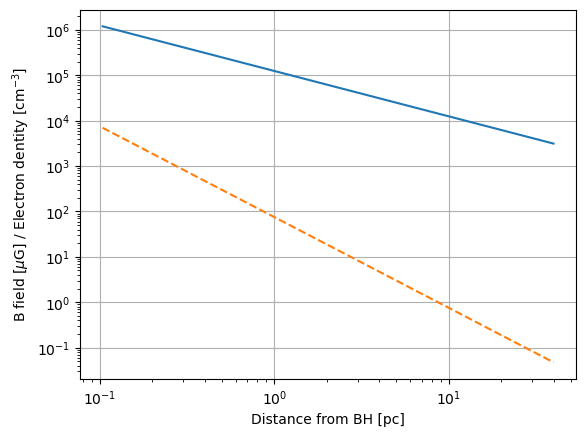

In [9]:
plt.loglog(ml.modules[0].r, ml.modules[0].B)
plt.loglog(ml.modules["Jet"].r, ml.modules["Jet"].nel, ls='--')  # list can also be accessed by module name
plt.grid(True)
plt.xlabel('Distance from BH [pc]')
plt.ylabel('B field [$\mu$G] / Electron dentity [cm$^{-3}$]')
print (ml.modules[0].B[-1],ml.modules[0]._r[-1])

## Compute the photon-ALP mixing probability

Now we can compute the mixing probability. First we change the ALP mass and coupling to photons

In [10]:
ml.alp.m = 100.
ml.alp.g = 0.3

And then compute the oscillation probability

In [11]:
px, py, pa = ml.run()
pgg = px + py  # the total photon survival probability
print (pgg.shape)

   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixJet'>
   core.py: 658 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>


(1, 2000)


/Users/mey/Python/gammaALPs/gammaALPs/base/transfer.py:799: UserWarning: Not all values of linear polarization are real values!
  warnings.warn("Not all values of linear polarization are real values!")
/Users/mey/Python/gammaALPs/gammaALPs/base/transfer.py:802: UserWarning: Not all values of circular polarization are real values!
  warnings.warn("Not all values of circular polarization are real values!")


### Plot the output

We plot the total oscillation probability `pgg` for the single B-field realization as a function of energy.
Note that the drop at the highest energies is due to the EBL absorption.

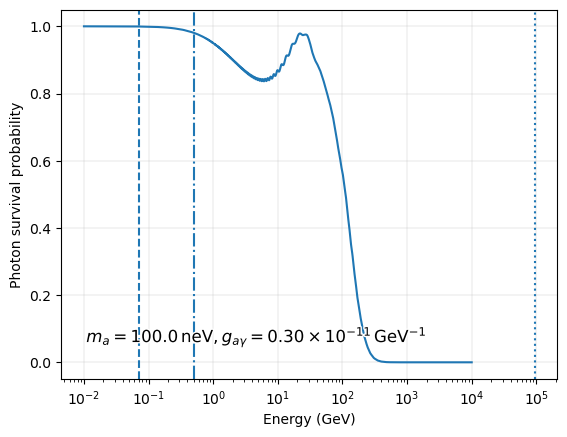

In [12]:
pgg = px + py  # the total photon survival probability

for p in pgg: # plot all realizations
    plt.plot(ml.EGeV, p)

plt.grid(True, lw = 0.2)
plt.grid(True, which = 'minor', axis = 'y', lw = 0.2)

plt.xlabel('Energy (GeV)')
plt.ylabel(r'Photon survival probability')

plt.gca().set_xscale('log')
plt.annotate(r'$m_a = {0:.1f}\,\mathrm{{neV}}, g_{{a\gamma}}'
             r' = {1:.2f} \times 10^{{-11}}\,\mathrm{{GeV}}^{{-1}}$'.format(ml.alp.m,ml.alp.g),
             xy=(0.05,0.1),
             size='large',
             xycoords='axes fraction',
             ha='left',
             **effect)

# Also plot the minimum and maximum energies for 
# different values of the electron density and magnetic fields
plt.axvline(transfer.EminGeV(ml.alp.m, ml.alp.g, ml.modules[0].nel[0], ml.modules[0].B[0]), ls='--')
plt.axvline(transfer.EminGeV(ml.alp.m, ml.alp.g, ml.modules[-1].nel[-1], ml.modules[-1].B[-1]), ls=':')
plt.axvline(transfer.EmaxGeV(ml.alp.g, ml.modules[0].B[0]), ls = '-.')